<a href="https://colab.research.google.com/github/Rhitabrat/deep-learning-CS510/blob/main/hw4/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HW4

References

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

https://smorbieu.gitlab.io/accuracy-from-classification-to-clustering-evaluation/

https://towardsdatascience.com/credit-card-customer-clustering-with-autoencoder-and-k-means-16654d54e64e

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

https://www.tensorflow.org/tutorials/generative/autoencoder

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras
import tensorflow as tf
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
(X_train_ori, y_train), (X_test_ori, y_test) = keras.datasets.mnist.load_data()
assert X_train_ori.shape == (60000, 28, 28)
assert X_test_ori.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [ ]:
def select_data(n, X_train, y_train):
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    indices_all_classes = []

    for each_class in classes:
        indices = [i for i, x in enumerate(y_train) if x == each_class]
        indices_all_classes.append(indices)

    new_X_train = []
    new_y_train = []

    for class_indices in indices_all_classes:
        x, y = X_train[class_indices[:n]], y_train[class_indices[:n]]
        new_X_train.extend(x)
        new_y_train.extend(y)

    return np.array(new_X_train), np.array(new_y_train)

In [ ]:
def prepare_data(X_train, y_train):
    X_train = X_train.astype('float32') / 255
    return X_train, y_train

# QN 1

Pick 100 samples from each of the 10 classes. Take all these 1,000 images and run them through a k-means clustering algorithm (k=10).

In [ ]:
# Nx10 data - 10 from each category

N=100
X_train_100, y_train_100 = select_data(N, X_train_ori, y_train)
X_train_100, y_train_100 = prepare_data(X_train_100, y_train_100)

X_train_100 = X_train_100.reshape(len(X_train_100), -1)
X_train_100.shape

(1000, 784)

## Kmeans

In [ ]:
kmeans = KMeans(init="k-means++", n_clusters=10, random_state=0).fit(X_train_100)
predicted_labels = kmeans.labels_

## Accuracy

In [ ]:
cm = confusion_matrix(y_train_100, predicted_labels)

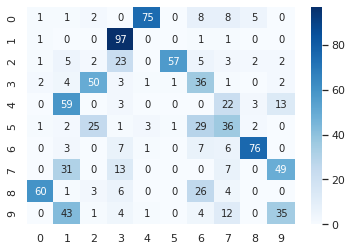

In [ ]:
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [ ]:
np.trace(cm) / np.sum(cm)

0.056

*Kmeans gives you cluster numbers that are different from the class labels. You have to convert those clusters numbers to their corresponding class labels, i.e if for example, if more than  50% of images in cluster 1 are from class 5, that cluster should be reassigned number 5.* - from TA

In [ ]:
def linear_assignment(cost_matrix):
  try:
    import lap
    _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
    return np.array([[y[i], i] for i in x if i >= 0])
  except ImportError:
    from scipy.optimize import linear_sum_assignment
    x, y = linear_sum_assignment(cost_matrix)
    return np.array(list(zip(x, y)))

def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

indexes = linear_assignment(_make_cost_m(cm))
js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
cm2 = cm[:, js]

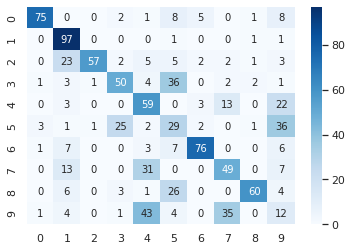

In [ ]:
ax = sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues")

In [ ]:
np.trace(cm2) / np.sum(cm2)

0.564

# QN 2

This time we will take 1,000 images from each of the 10 MNIST classes giving us 10,000 images. Build an autoencoder and train it.

In [ ]:
# Nx10 data - 10 from each category

N=1000
X_train_1000, y_train_1000 = select_data(N, X_train_ori, y_train)
X_train_1000, y_train_1000 = prepare_data(X_train_1000, y_train_1000)

X_test_1000, y_test_1000 = select_data(N, X_test_ori, y_test)
X_test_1000, y_test_1000 = prepare_data(X_test_1000, y_test_1000)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [ ]:
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AutoEncoder()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(X_train_1000, X_train_1000,
                epochs=10,
                shuffle=True,
                validation_data=(X_test_ori, X_test_ori))

Epoch 1/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0481 - val_loss: 7345.0654
Epoch 2/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0047 - val_loss: 7344.1406
Epoch 3/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0033 - val_loss: 7343.8174
Epoch 4/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0027 - val_loss: 7343.6904
Epoch 5/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0024 - val_loss: 7343.4775
Epoch 6/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0022 - val_loss: 7343.3838
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0020 - val_loss: 7343.3398
Epoch 8/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0019 - val_loss: 7343.3384
Epoch 9/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0018 - val_loss: 7343.3311
Epoch 10/10
313/313 [==============================] - 2s 5ms/step - loss

In [85]:
encoded_imgs = autoencoder.encoder(X_test_ori).numpy()
encoded_imgs = encoded_imgs.reshape(len(encoded_imgs), -1)

In [86]:
kmeans = KMeans(init="k-means++", n_clusters=10, random_state=0).fit(encoded_imgs)
predicted_labels = kmeans.labels_
cm = confusion_matrix(y_test, predicted_labels)

In [87]:
indexes = linear_assignment(_make_cost_m(cm))
js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
cm2 = cm[:, js]

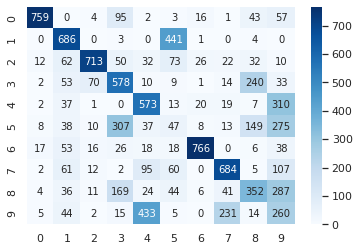

In [88]:
ax = sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues")

In [89]:
np.trace(cm2) / np.sum(cm2)

0.5418

In [90]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
reduced_data = pca.fit_transform(encoded_imgs)
reduced_data.shape

(10000, 2)

In [91]:
kmeans = KMeans(init="k-means++", n_clusters=10, random_state=0).fit(reduced_data)
predicted_labels = kmeans.labels_
cm = confusion_matrix(y_test, predicted_labels)

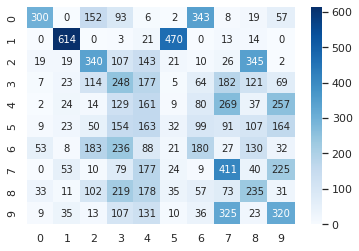

In [92]:
indexes = linear_assignment(_make_cost_m(cm))
js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
cm2 = cm[:, js]

ax = sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues")

In [93]:
np.trace(cm2) / np.sum(cm2)

0.2841

#QN 3

Start with an untrained autoencoder. Train it by adding noise input images and using the original images to compare against.

In [ ]:
def de_noising(amount_of_denoise):
    noise_factor = amount_of_denoise
    x_train_noisy = X_train_1000 + noise_factor * tf.random.normal(shape=X_train_1000.shape)
    x_test_noisy = X_test_ori + noise_factor * tf.random.normal(shape=X_test_ori.shape)

    x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
    x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

    autoencoder.fit(x_train_noisy, X_train_1000,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, X_test_ori))
    
    encoded_imgs = autoencoder.encoder(X_test_ori).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.title("original")
        plt.imshow(tf.squeeze(X_test_ori[i]))
        plt.gray()
    plt.show()

    plt.figure(figsize=(20, 4))
    for i in range(n):

        # display original + noise
        ax = plt.subplot(2, n, i + 1)
        plt.title("original + noise")
        plt.imshow(tf.squeeze(x_test_noisy[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed")
        plt.imshow(tf.squeeze(decoded_imgs[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    plt.show()

Epoch 1/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0040 - val_loss: 7344.9673
Epoch 2/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0038 - val_loss: 7345.3110
Epoch 3/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0037 - val_loss: 7344.7974
Epoch 4/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0036 - val_loss: 7344.9570
Epoch 5/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0036 - val_loss: 7345.0239
Epoch 6/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0035 - val_loss: 7344.9414
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0035 - val_loss: 7345.0713
Epoch 8/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0034 - val_loss: 7344.8345
Epoch 9/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0034 - val_loss: 7344.8833
Epoch 10/10
313/313 [==============================] - 2s 5ms/step - loss

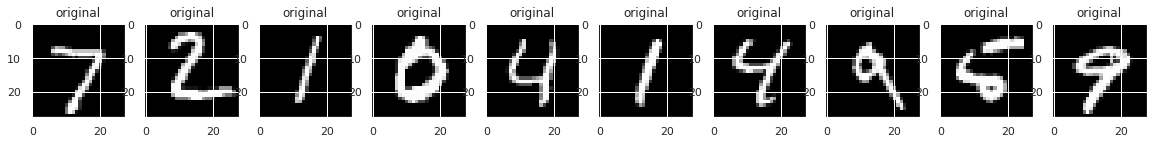

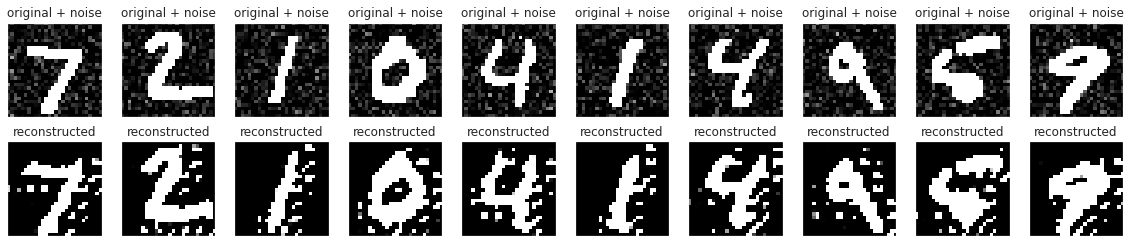

In [ ]:
de_noising(0.2)

##Bonus

Experiment with 5 different amounts of noise and show the results.

Epoch 1/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0102 - val_loss: 7345.0815
Epoch 2/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0098 - val_loss: 7345.2598
Epoch 3/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0096 - val_loss: 7345.0942
Epoch 4/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0095 - val_loss: 7345.3032
Epoch 5/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0095 - val_loss: 7345.5312
Epoch 6/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0094 - val_loss: 7345.3086
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0094 - val_loss: 7345.3423
Epoch 8/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0094 - val_loss: 7345.3184
Epoch 9/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0093 - val_loss: 7345.6265
Epoch 10/10
313/313 [==============================] - 2s 6ms/step - loss

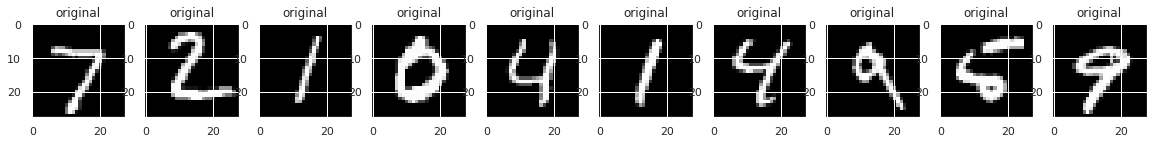

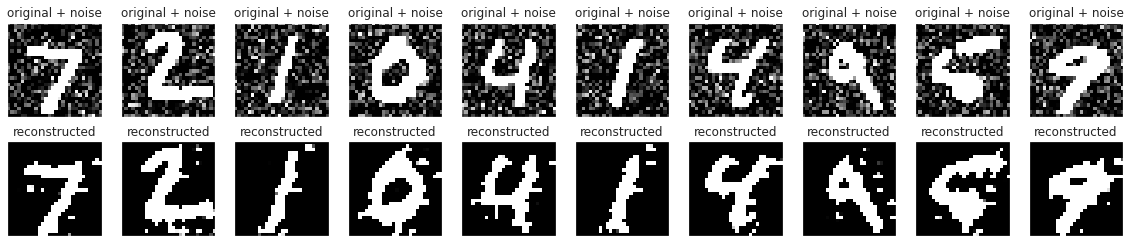

In [ ]:
de_noising(0.4)

Epoch 1/10
313/313 [==============================] - 2s 7ms/step - loss: 0.0139 - val_loss: 7345.9297
Epoch 2/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0138 - val_loss: 7345.8945
Epoch 3/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0137 - val_loss: 7346.0078
Epoch 4/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0137 - val_loss: 7345.8950
Epoch 5/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0136 - val_loss: 7345.8560
Epoch 6/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0135 - val_loss: 7346.1768
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0135 - val_loss: 7345.6362
Epoch 8/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0135 - val_loss: 7345.5410
Epoch 9/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0134 - val_loss: 7346.0640
Epoch 10/10
313/313 [==============================] - 2s 7ms/step - loss

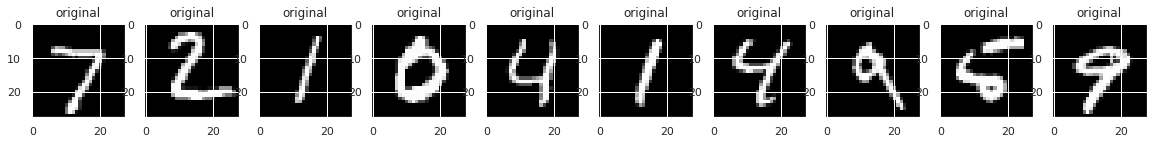

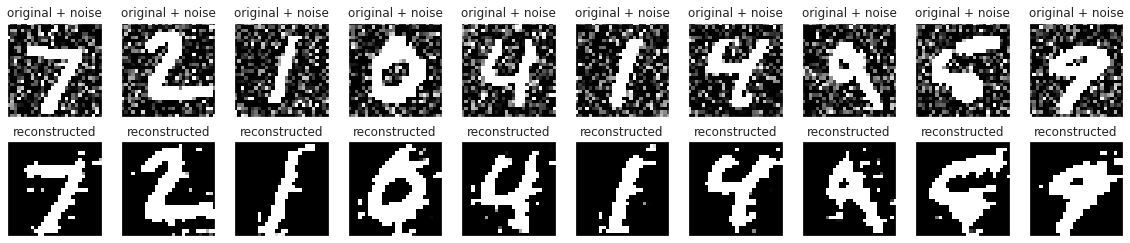

In [ ]:
de_noising(0.5)

Epoch 1/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0186 - val_loss: 7346.1982
Epoch 2/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0185 - val_loss: 7345.8086
Epoch 3/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0184 - val_loss: 7345.4414
Epoch 4/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0183 - val_loss: 7345.7402
Epoch 5/10
313/313 [==============================] - 2s 6ms/step - loss: 0.0182 - val_loss: 7345.8369
Epoch 6/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0182 - val_loss: 7345.5190
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0181 - val_loss: 7345.3770
Epoch 8/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0180 - val_loss: 7345.5127
Epoch 9/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0180 - val_loss: 7345.6841
Epoch 10/10
313/313 [==============================] - 2s 5ms/step - loss

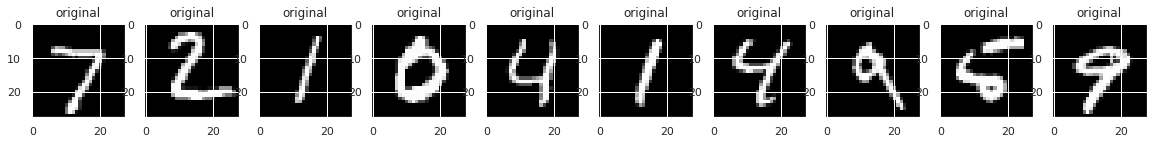

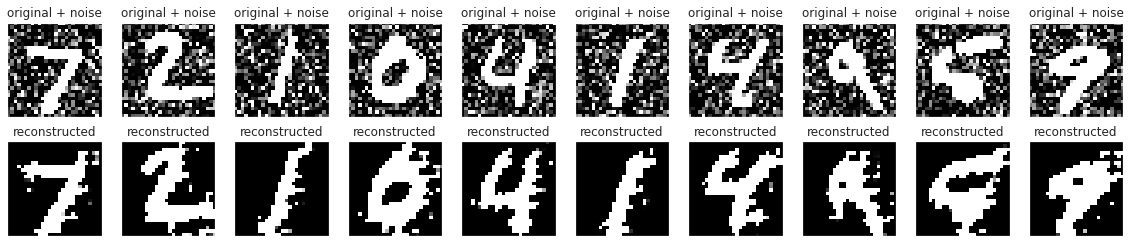

In [ ]:
de_noising(0.6)

Epoch 1/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0292 - val_loss: 7346.1406
Epoch 2/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0289 - val_loss: 7345.4360
Epoch 3/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0288 - val_loss: 7345.4878
Epoch 4/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0287 - val_loss: 7346.0015
Epoch 5/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0286 - val_loss: 7345.8047
Epoch 6/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0286 - val_loss: 7345.6558
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0285 - val_loss: 7345.8945
Epoch 8/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0285 - val_loss: 7345.7334
Epoch 9/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0285 - val_loss: 7345.5439
Epoch 10/10
313/313 [==============================] - 2s 5ms/step - loss

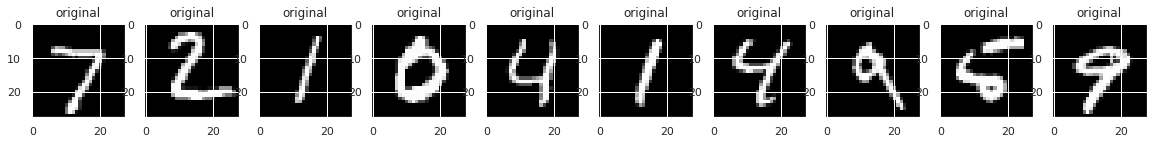

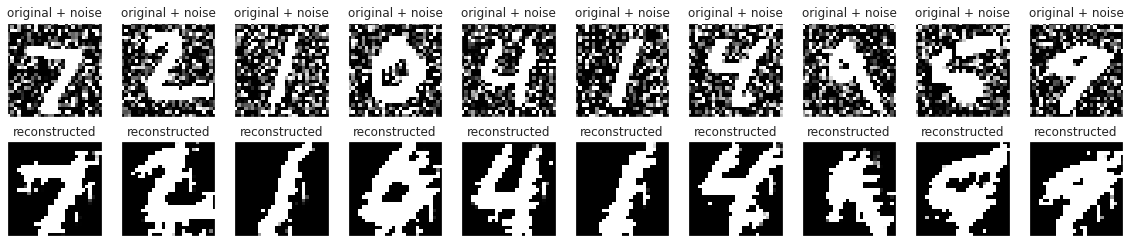

In [ ]:
de_noising(0.8)

Epoch 1/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0336 - val_loss: 7345.9458
Epoch 2/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0335 - val_loss: 7345.8745
Epoch 3/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0335 - val_loss: 7346.0610
Epoch 4/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0334 - val_loss: 7346.1606
Epoch 5/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0334 - val_loss: 7346.1377
Epoch 6/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0333 - val_loss: 7345.8472
Epoch 7/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0333 - val_loss: 7346.1177
Epoch 8/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0333 - val_loss: 7345.7847
Epoch 9/10
313/313 [==============================] - 2s 5ms/step - loss: 0.0332 - val_loss: 7346.2881
Epoch 10/10
313/313 [==============================] - 2s 5ms/step - loss

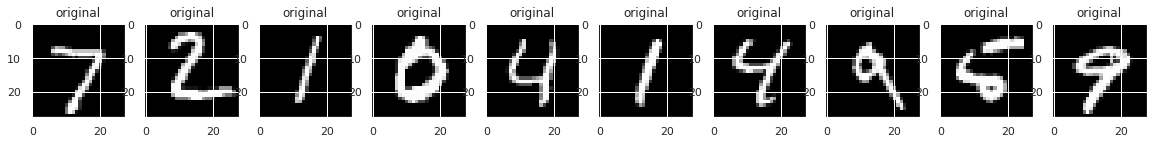

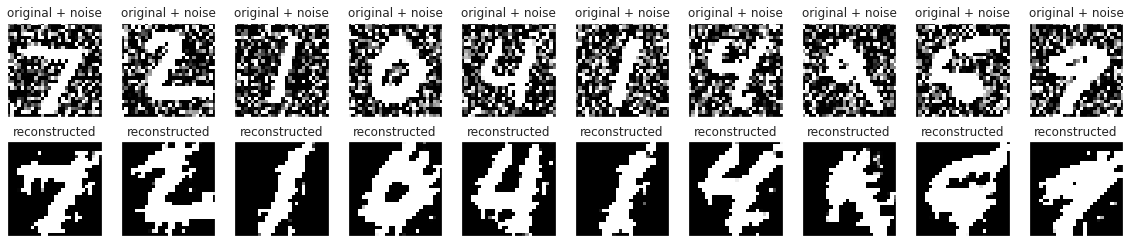

In [ ]:
de_noising(0.9)